In [ ]:
import torch
import numpy as np

## 3.1 Автоматическое дифференцирование в `torch`

3.1.1 Воспользовавшись классами `Neuron` и `SquaredLoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [ ]:
from sklearn.datasets import make_regression

# Данные
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [ ]:
class Neuron:
  def __init__(self, n_features):
    # <создать атрибуты объекта weights и bias>
    self.w = torch.randn(n_features, requires_grad = True) # вектор
    self.b = torch.randn(1,  requires_grad = True) # скалярное значение

  def forward(self, inputs):
    self.inputs = inputs
    y_pred = torch.dot(inputs, self.w) + self.b # внутреннее произведение двух тензоров одинаковой формы.
    return  y_pred # <реализовать логику нейрона> умножение матрицы на вектор

  def backward(self):
    # dvalue - значение производной, которое приходит нейрону от следующего слоя сети
    # в данном случае это будет значение df/dc (созданное методом backwards у объекта MSELoss)
    self.dw = self.w.grad
    self.db = self.b.grad

In [ ]:
class SquaredLoss:
  def forward(self, y_pred, y_true):
    self.loss = ((y_pred - y_true)**2)
    return self.loss # <реализовать логику MSE>

  def backward(self): # производная
     self.loss.backward()

In [ ]:
n_inputs = X.size()[1] # <размерность элемента выборки >
learning_rate = 0.1 #  скорость обучения
n_epoch = 100 #  количество эпох

neuron = Neuron(n_inputs)
loss = SquaredLoss()

In [ ]:
losses = []
for epoch in range(100):
  # Проход по всем тренировочным примерам
  for x_example, y_example in zip(X, y):
    # forward pass
    y_pred = neuron.forward(x_example) # <прогон через нейрон>
    curr_loss = loss.forward(y_pred, y_example) # <прогон через функцию потерь>
    # print(curr_loss)
    losses.append(curr_loss.item())

    # backprop

    # <вызов методов backward>
    loss.backward() # атрибут класса
    neuron.backward()
    # <шаг оптимизации для весов (weights и bias) нейрона>
    with torch.no_grad():
      neuron.w -= learning_rate*neuron.dw
      neuron.b -= learning_rate*neuron.db
    neuron.w.grad.zero_()
    neuron.b.grad.zero_()

In [ ]:
coef

array([74.32120726, 51.84403108, 85.81184929, 31.98410349])

In [ ]:
neuron.w, neuron.b

(tensor([74.3212, 51.8440, 85.8119, 31.9841], requires_grad=True),
 tensor([0.5000], requires_grad=True))

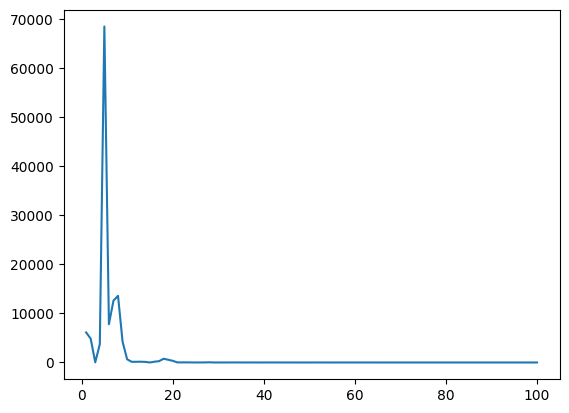

In [ ]:
import matplotlib.pyplot as plt
import numpy

with torch.no_grad():
  index = list(range(1, len(losses)+1))
  plt.plot(index[:100], losses[:100])

3.1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [ ]:
# ДЗ
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
class Linear:
    def __init__(self, n_features, n_output):
        # <создать атрибуты объекта weights и biases>
        self.weights = torch.randn(n_features, n_output, requires_grad = True)
        self.biases = torch.randn(1, n_output, requires_grad = True)

    def forward(self, inputs):
        self.inputs = inputs
        return (inputs @ self.weights) + self.biases # <реализовать логику слоя>

    def backward(self):
      self.dw = self.weights.grad
      self.db = self.bias.grad

In [ ]:
class MSELoss:
  def forward(self, y_pred, y_true):
    self.loss = ((y_pred.view(-1, 1) - y_true.view(-1, 1)) ** 2).mean()
    return self.loss # <реализовать логику MSE>

  def backward(self):
        self.loss.backward()

Метод backward() является частью библиотеки глубокого обучения PyTorch и используется для обратного распространения ошибки (backpropagation). Он вычисляет градиенты для всех параметров, которые влияют на значение self.loss, и сохраняет эти градиенты в соответствующих переменных. Градиенты затем используются для обновления весов модели во время процесса обучения.

In [ ]:
class ReLU:
  def forward(self, inputs):
    self.inputs = inputs
    self.output = inputs.clip(min=0)
    return self.output

  def backward(self, dvalues):
    self.dinputs = dvalues.clone()
    self.dinputs[self.inputs <= 0] = 0


In [ ]:
n_inputs = X.size()[1] # <размерность элемента выборки >
lr = 0.01 #  скорость обучения
n_epoch = 100 #  количество эпох

loss = MSELoss()

In [ ]:
# создание компонентов сети
fc1 = Linear(1, 15)
relu1 = ReLU()
fc2 = Linear(15, 1)

optimizer = torch.optim.Adam([fc1.weights, fc1.biases, fc2.weights, fc2.biases], lr = lr)

losses = []
ys = []
for epoch in range(100000):

  # fc1 > relu1 > fc2 > loss
  #y1_pred = fc1.forward(X) Первый слой дает первые предскзаания
  #yr_pred = relu1.forward(y1_pred)
  #y_pred = fc2.forward(yr_pred)

  y_pred = fc2.forward(relu1.forward(fc1.forward(X)))

  cur_loss = loss.forward(y_pred, y) # Прогон через функцию потерь MSELoss
  losses.append(cur_loss.detach())

  if epoch % 10000 == 0:
    print(f'epoch {epoch} mean loss {cur_loss}')
    ys.append(y_pred)

  # loss > fc2 > relu1 > fc1
  #with torch.no_grad():
  cur_loss.backward()
    #optimizer.step()
    #optimizer.zero_grad()
  with torch.no_grad():

    # <шаг оптимизации для fc1>
    fc1.weights -= lr * fc1.weights.grad
    fc1.biases -= lr * fc1.biases.grad
    # <шаг оптимизации для fc2>
    fc2.weights -= lr * fc2.weights.grad
    fc2.biases -= lr * fc2.biases.grad
  #optimizer.zero_grad()
  fc1.weights.grad.zero_()
  fc1.biases.grad.zero_()
  fc2.weights.grad.zero_()
  fc2.biases.grad.zero_()

epoch 0 mean loss 5.953935623168945
epoch 10000 mean loss 0.02177378162741661
epoch 20000 mean loss 0.005119378678500652
epoch 30000 mean loss 0.004366403911262751
epoch 40000 mean loss 0.004245101008564234
epoch 50000 mean loss 0.004162150900810957
epoch 60000 mean loss 0.004100922495126724
epoch 70000 mean loss 0.004056200850754976
epoch 80000 mean loss 0.0040237815119326115
epoch 90000 mean loss 0.004000367596745491


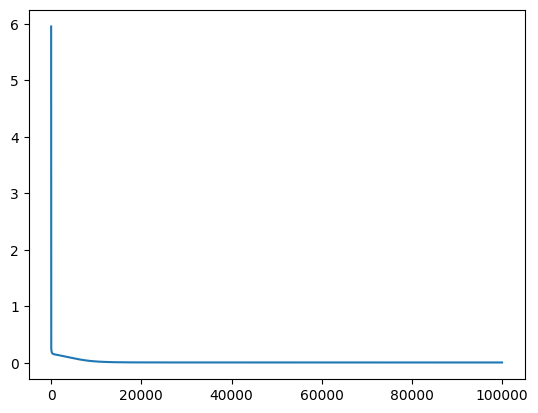

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses) # ys[-1], y_true

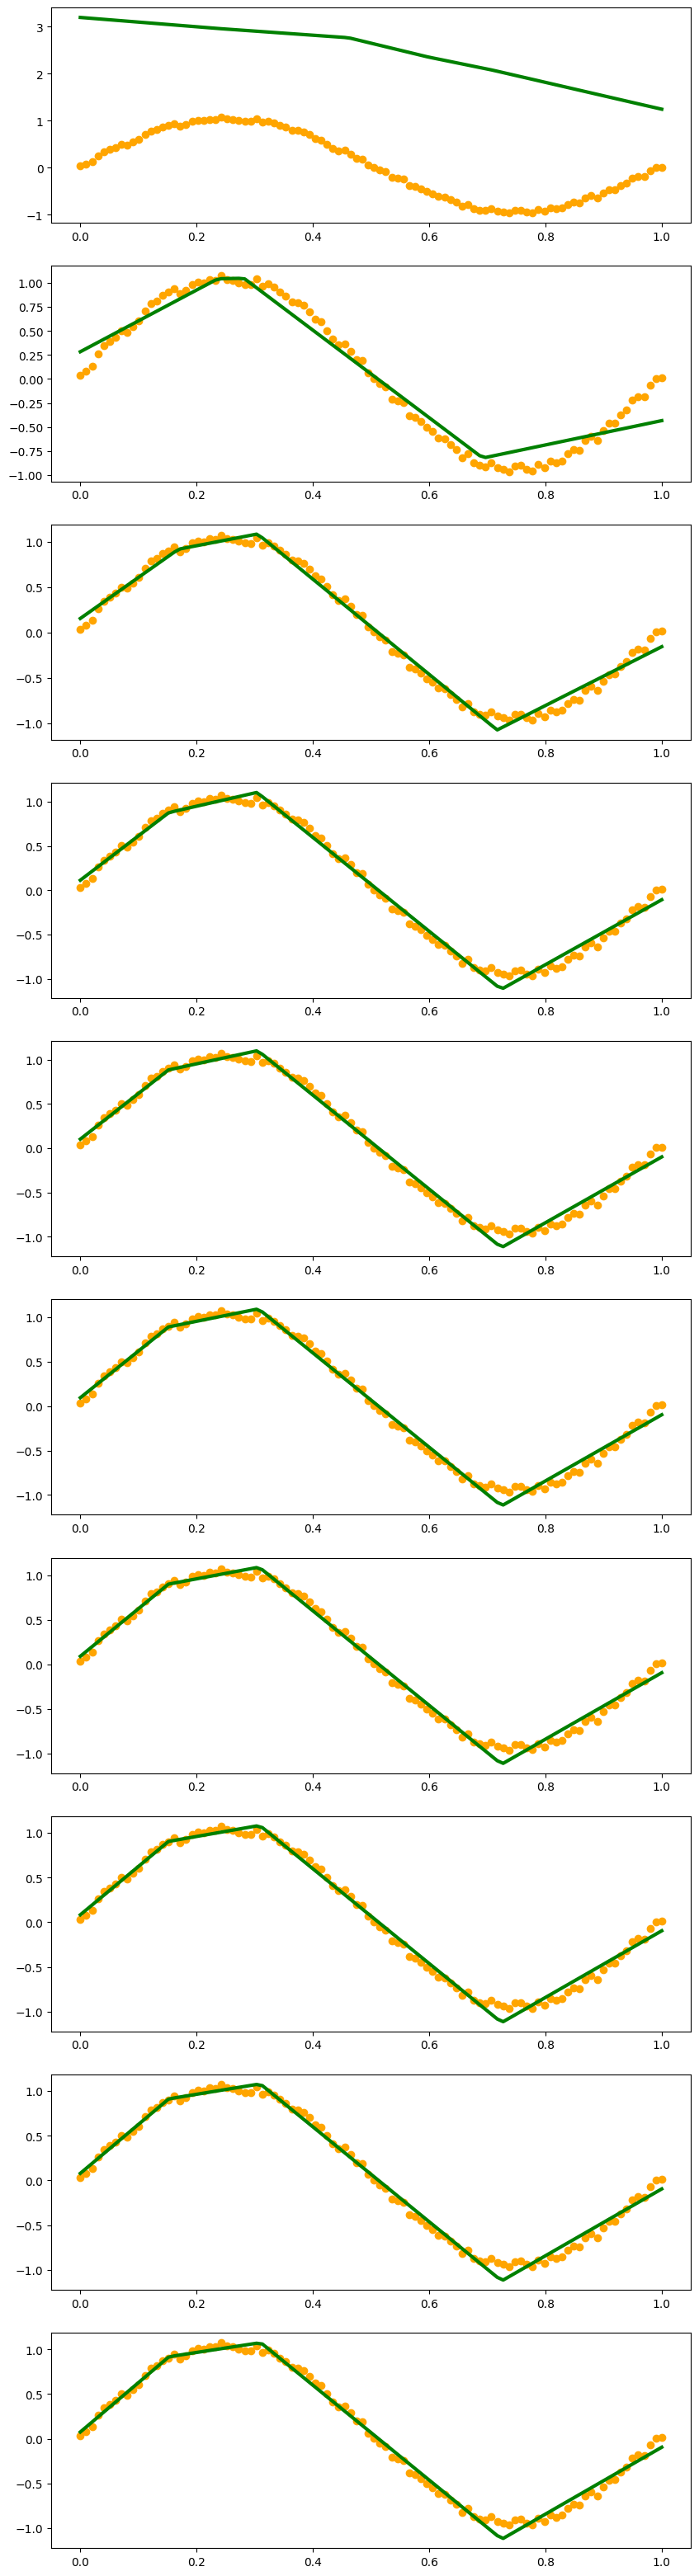

In [ ]:
fig, axs = plt.subplots(len(ys), 1, figsize=(10, 40))
for ax, y_ in zip(axs, ys):
  ax.scatter(X.numpy(), y.numpy(), color = 'orange')
  ax.plot(X.numpy(), y_.detach().numpy(), 'g', lw = 3)

## 3.2 Алгоритмы оптимизации в `torch.optim`

1. no_grad: Функция no_grad используется для отключения вычисления градиентов во время прямого прохода (forward pass) модели. Это полезно, когда мы хотим использовать обученную модель только для предсказания, а не для обновления параметров. Отключение вычисления градиентов может ускорить выполнение и потребление памяти.

2. zero_grad: Метод zero_grad используется для обнуления градиентов всех параметров модели перед началом обратного прохода (backward pass). Это необходимо, чтобы предотвратить накопление градиентов между итерациями обучения.

3. optimizer.step(): Метод optimizer.step() вызывается после вычисления градиентов во время обратного прохода и используется для обновления параметров модели на основе этих градиентов. Оптимизатор (например, Adam или SGD) применяет определенный алгоритм оптимизации для обновления параметров с учетом скорости обучения и других настроек.


Оптимизаторы Adam и SGD (Stochastic Gradient Descent) являются двумя популярными алгоритмами оптимизации для обучения нейронных сетей. Они имеют различные особенности и применяются в разных ситуациях.

Основные отличия между Adam и SGD:

1. Алгоритм оптимизации: Adam использует метод адаптивной оптимизации, который комбинирует идеи из алгоритмов Momentum и RMSprop. С другой стороны, SGD является классическим методом градиентного спуска.

2. Обновление скорости обучения: В Adam скорость обучения (learning rate) автоматически адаптируется на основе первого и второго моментов градиента. В SGD скорость обучения остается постоянной или может быть регулирована вручную.

3. Скорость сходимости: Adam может обеспечить более быструю сходимость в задачах с большим количеством параметров и разреженными градиентами. Однако в некоторых случаях SGD может достичь лучших результатов, особенно при использовании подходов, таких как learning rate annealing или momentum.

4. Параметры: Adam имеет несколько дополнительных параметров, таких как beta1 и beta2, которые контролируют экспоненциальное сглаживание градиента и квадратов градиента соответственно. В SGD обычно используется только скорость обучения.

5. Вычислительная сложность: Adam может быть более вычислительно сложным, чем SGD, из-за дополнительных вычислений первого и второго моментов градиента.

В целом, выбор между Adam и SGD зависит от конкретной задачи и данных. Adam часто используется в практике обучения нейронных сетей, так как он обычно показывает хорошую производительность и не требует настройки скорости обучения вручную. Однако, в некоторых случаях SGD может быть предпочтительнее, особенно при использовании определенных техник оптимизации.

In [ ]:
import torch.optim as optim

3.2.1 Решить задачу 3.1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

In [ ]:
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [ ]:
class Neuron:
  def __init__(self, n_features):
    self.w = torch.randn(n_features, requires_grad = True)
    self.b = torch.randn(1,  requires_grad = True)

  def forward(self, inputs):
    self.inputs = inputs
    y_pred = torch.dot(inputs, self.w) + self.b
    return  y_pred

In [ ]:
class SquaredLoss:
  def forward(self, y_pred, y_true):
    self.loss = ((y_pred - y_true)**2).mean()
    return self.loss # <реализовать логику MSE>

  def backward(self): # производная
     self.loss.backward()

In [ ]:
losses = []
for epoch in range(100):
  # Проход по всем тренировочным примерам
  for x_example, y_example in zip(X, y):
    # forward pass
    y_pred = neuron.forward(x_example) # <прогон через нейрон>
    curr_loss = loss.forward(y_pred, y_example) # <прогон через функцию потерь>
    # print(curr_loss)
    losses.append(curr_loss)

    # backprop

    # <вызов методов backward>
    loss.backward() # атрибут класса

    # <шаг оптимизации для весов (weights и bias) нейрона>
    optimizer.step()
    optimizer.zero_grad()

3.2.2 Решить задачу 3.1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
class MSELoss:
    def forward(self, y_pred, y_true):
        self.loss = ((y_pred.view(-1, 1) - y_true.view(-1, 1)) ** 2).mean()
        return self.loss

    def backward(self):
        self.loss.backward()

In [ ]:
class ReLU:
    def forward(self, inputs):
        self.output = inputs.clip(min=0)
        return self.output

In [ ]:
class Linear:
    def __init__(self, n_features, n_output):
        # <создать атрибуты объекта weights и biases>
        self.weights = torch.randn(n_features, n_output, requires_grad = True)
        self.biases = torch.randn(1, n_output, requires_grad = True)

    def forward(self, inputs):
        self.inputs = inputs
        return (inputs @ self.weights) + self.biases # <реализовать логику слоя>

In [ ]:
# создание компонентов сети
fc1 = Linear(1, 15)
relu1 = ReLU()
fc2 = Linear(15, 1)

loss = MSELoss()
lr = 0.01

optimizer = torch.optim.Adam([fc1.weights, fc1.biases, fc2.weights, fc2.biases], lr=lr)

ys = []
losses = []
for epoch in range(100000):

    y_pred = fc2.forward(relu1.forward(fc1.forward(X)))

    data_loss = loss.forward(y_pred, y) # <прогон через функцию потерь>
    losses.append(data_loss.item())
    if epoch % 10000 == 0:
        print(f'epoch {epoch} mean loss {data_loss}')
        ys.append(y_pred)

    # <backprop>
    # loss > fc2 > relu1 > fc1
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

epoch 0 mean loss 33.3807258605957
epoch 10000 mean loss 0.14411921799182892
epoch 20000 mean loss 0.14400967955589294
epoch 30000 mean loss 0.004623368848115206
epoch 40000 mean loss 0.00433335592970252
epoch 50000 mean loss 0.004340178798884153
epoch 60000 mean loss 0.00416972953826189
epoch 70000 mean loss 0.004146075341850519
epoch 80000 mean loss 0.004143110942095518
epoch 90000 mean loss 0.004144356120377779


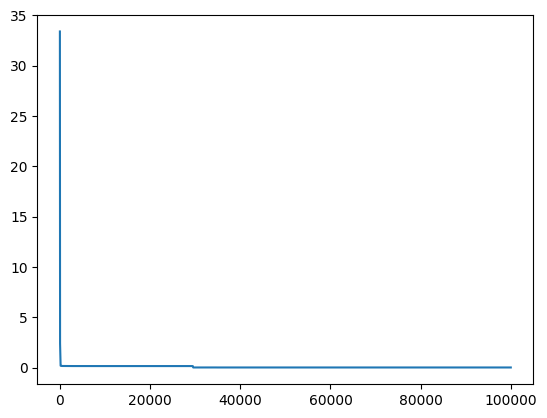

In [ ]:
plt.plot(losses)

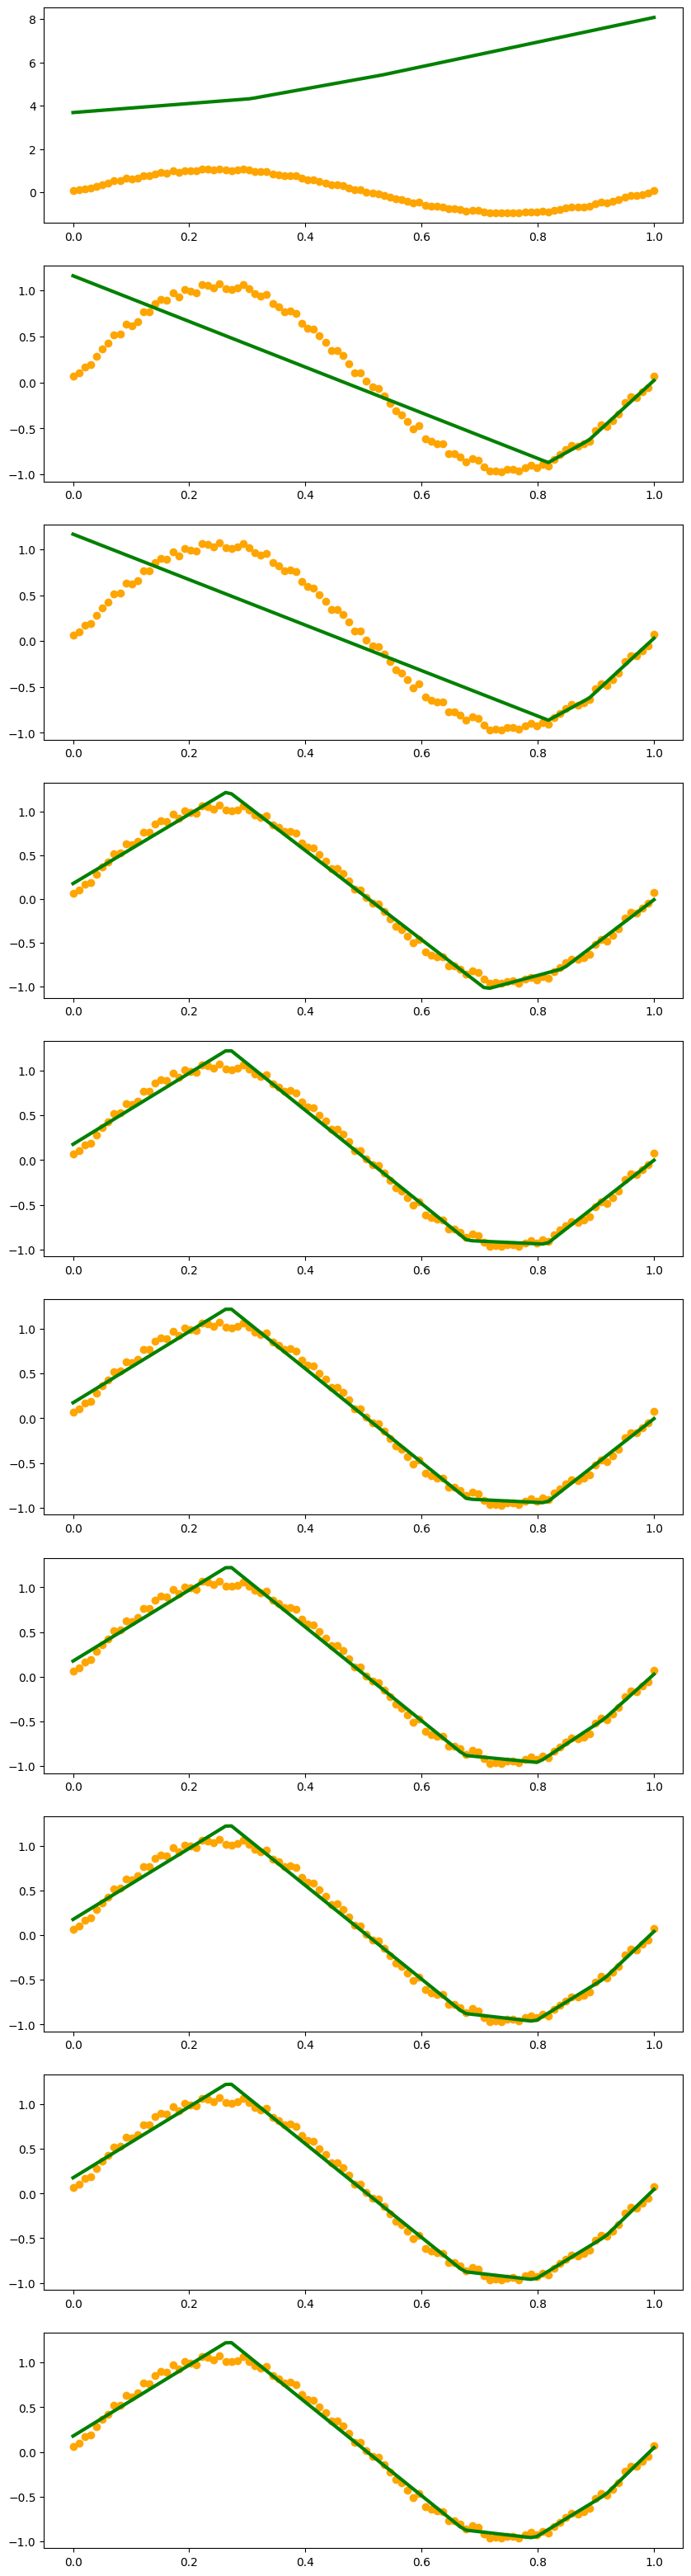

In [ ]:
fig, axs = plt.subplots(len(ys), 1, figsize=(10, 40))
for ax, y_ in zip(axs, ys):
  ax.scatter(X.numpy(), y.numpy(), color = 'orange')
  ax.plot(X.numpy(), y_.detach().numpy(), 'g', lw = 3)

## 3.3 Построение сетей при помощи `torch.nn`

In [ ]:
import torch.nn as nn

3.3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim`

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(SineNet, self).__init__()
        self.fc1 = nn.Linear(1, n_hidden_neurons) # Полносвязный слой 1

        self.act1 = nn.Sigmoid() # Функция активации сигмоид
        self.fc2 = nn.Linear(n_hidden_neurons, 1) # Полносвязный слой 21

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

sine_net = SineNet(50)

In [ ]:
def predict(net, X, y):
        y_pred = net.forward(X)

        plt.figure(figsize=(10, 5))
        plt.plot(X.numpy(), y.numpy(), 'o', c='orange')
        plt.plot(X.numpy(), y_pred.data.numpy(), c='g');

In [ ]:
optimizer = torch.optim.Adam(sine_net.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

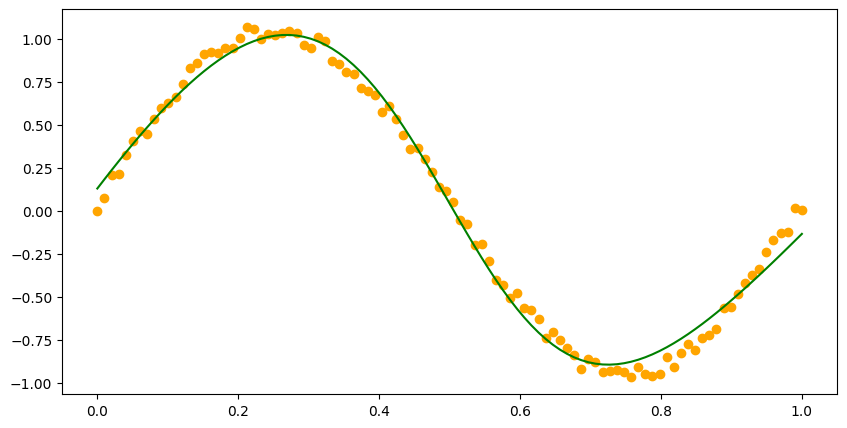

In [ ]:
for epoch in range(1001):
    optimizer.zero_grad()

    y_pred = sine_net.forward(X)
    loss_val = criterion.forward(y_pred, y)

    loss_val.backward()

    optimizer.step()

predict(sine_net, X, y)

3.3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim`

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
model = nn.Sequential( # Создание модели
    nn.Linear(1, 50), # Полносвязный слой с 1 входом и 50 выходами
    nn.Sigmoid(), # Функция активации сигмоид
    nn.Linear(50,1) # Полносвязный слой с 50 входами и 1 выходом
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

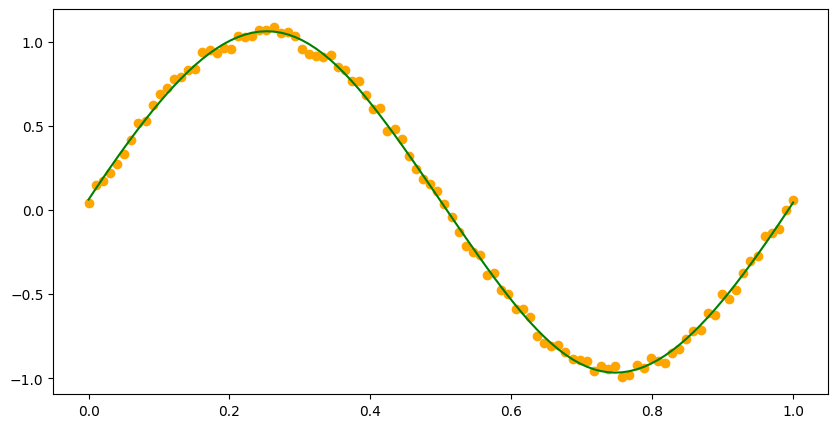

In [ ]:
for epoch in range(10000):
    optimizer.zero_grad()

    y_pred = model.forward(X)
    loss_val = criterion.forward(y_pred, y)
    loss_val.backward()
    optimizer.step()

predict(model, X, y)

## 3.4. Datasets and dataloaders

Dataset и DataLoader являются **классами** из модуля torch.utils.data в библиотеке PyTorch и используются для обработки и загрузки данных в модели машинного обучения.


torch.utils.data используется для упрощения работы с данными в PyTorch.

In [ ]:
from torch.utils.data import Dataset, DataLoader

Класс Dataset представляет собой абстракцию данных и предоставляет методы для доступа к ним. Он определяет два обязательных метода: __len__(), который возвращает **размер набора данных**, и __getitem__(), который возвращает элемент данных по индексу. Класс Dataset может быть настроен для работы с различными типами данных, такими как изображения, текст или аудио.


3.4.1 Создать датасет, поставляющий данные из задачи 3.1.2.

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.3.1 (или 3.3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [ ]:
class SinDataset(Dataset):
  def __init__(self):
        self.n_samples = X.shape[0]
        self.X = X
        self.y = y

  def __len__(self):
        return self.n_samples

  def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 50),
    nn.Sigmoid(),
    nn.Linear(50,1)
)
dataset = SinDataset()
dataloader = DataLoader(dataset, batch_size=10) # Загружает данные в виде пакетов заданного размера (batch)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

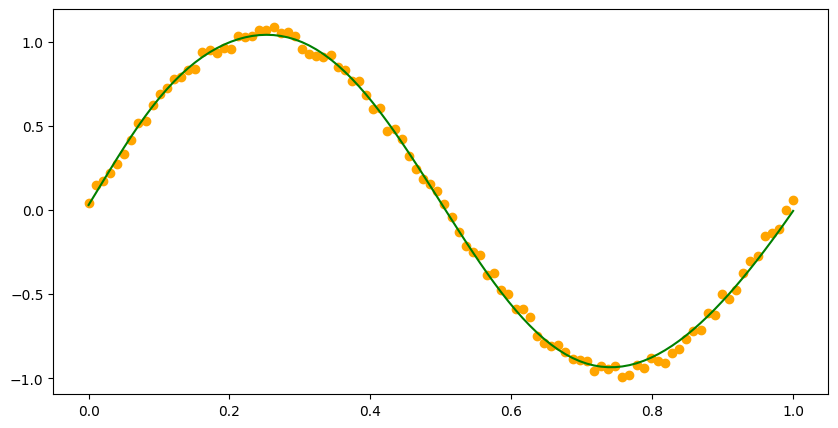

In [ ]:
for epoch_index in range(3000):
    for x_example, y_example in dataloader:
        optimizer.zero_grad()

        y_pred = model.forward(x_example)
        loss_val = criterion.forward(y_pred, y_example)

        loss_val.backward()

        optimizer.step()

predict(model, X, y)

3.4.2 Предсказание цен алмазов

3.4.2.1 Создайте датасет на основе файла diamonds.csv.

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров

3.4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.

3.4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`).

3.4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке.


In [ ]:
import pandas as pd

diamonds = pd.read_csv('diamonds.csv', index_col=0)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
class DiamondsDataset(Dataset):
  def __init__(self, data):
    data = data.select_dtypes(exclude='object') # Выбираем только числовые значения в данных
    self.data_x = torch.from_numpy(data.drop("price", axis=1).values).float()
    self.data_y = torch.from_numpy(data[["price"]].values).float()
    self.n_samples = self.data_x.shape[0]


  def __len__(self):
    return self.n_samples

  def __getitem__(self, idx):
    return self.data_x[idx], self.data_y[idx]

In [ ]:
dataset = DiamondsDataset(diamonds)
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2]) # Разбиваем данные на выборки тестовую и обучающую
dataloader = DataLoader(dataset=train, batch_size=256)

model = nn.Sequential(
    nn.BatchNorm1d(dataset.data_x.shape[-1]), # слой BatchNorm1d - нормализует входные данные по каждому признаку (столбцу) в пределах пакета данных
    nn.Linear(dataset.data_x.shape[-1], 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100,1)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

In [ ]:
losses_all = []

for epoch in range(101):
    losses = torch.empty(0)
    for x_example, y_example in dataloader:
        y_pred = model(x_example)
        loss = criterion(y_pred, y_example)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = torch.cat((losses, loss.view(1)))

    if epoch % 10 == 0:
        print('epoch', epoch, 'loss', losses.mean().item())
    losses_all.append(losses.mean().item())

epoch 0 loss 2128635008.0
epoch 10 loss 560419584.0
epoch 20 loss 553795264.0
epoch 30 loss 547078784.0
epoch 40 loss 541325248.0
epoch 50 loss 537527616.0
epoch 60 loss 534139488.0
epoch 70 loss 526693504.0
epoch 80 loss 516158240.0
epoch 90 loss 512595072.0
epoch 100 loss 510401984.0


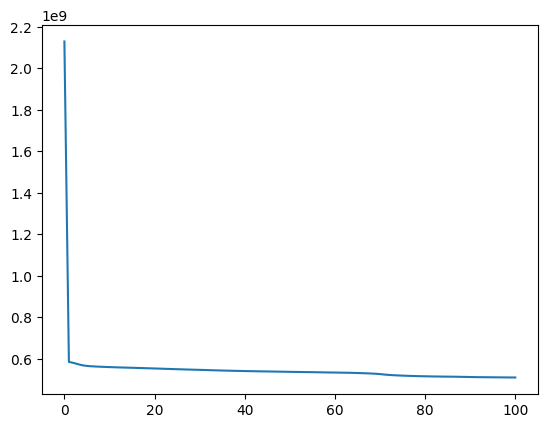

In [ ]:
plt.plot(losses_all)

In [ ]:
dataloader = DataLoader(dataset=test, batch_size=256)
losses = torch.empty(0)
for x_example, y_example in dataloader:
    y_pred = model(x_example)
    loss = criterion(y_pred, y_example)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses = torch.cat((losses, loss.view(1)))

print(losses.mean().item())

815598208.0


In [ ]:
dataset.__getitem__(0)

(tensor([ 0.2300, 61.5000, 55.0000,  3.9500,  3.9800,  2.4300]),
 tensor([326.]))

3.4.3 Модифицируйте метод `__init__` датасета из 3.4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [ ]:
class DiamondsDataset(Dataset):
    def __init__(self, data, transform):
        self.n_samples = data.shape[0]
        self.transform = transform
        self.x_data = data.drop("price", axis=1).values
        self.y_data = data[["price"]].values

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):

        sample = self.x_data[idx], self.y_data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
class DropColsTransform:
    def __init__(self, drop):
        self.drop = drop # Список индексов столбцов, которые нужно удалить

    def __call__(self, sample):
        X, y = sample # кортеж (X, y), где X - матрица признаков, а y - вектор целевых значений
        X = np.delete(X, self.drop, 0) # Здесь происходит удаление столбцов, указанных в списке drop
        return X, y

In [ ]:
class ToTensorTransform: # Трансформация в тензор
    def __call__(self, sample):
        X, y = sample
        X = torch.from_numpy(X.astype("float")).float().view(-1)
        y = torch.from_numpy(y.astype("float")).float().view(-1)
        return X, y

In [ ]:
from torchvision import transforms

drop = DropColsTransform(drop=[1, 2, 3])
to_tensor = ToTensorTransform()
dataset = DiamondsDataset(diamonds, transforms.Compose([drop, to_tensor]))


In [ ]:
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2])
dataloader = DataLoader(dataset=train, batch_size=256)

model = nn.Sequential(
    nn.BatchNorm1d(6),
    nn.Linear(6, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100,1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

epoch 0 loss 2233539072.0
epoch 25 loss 570250176.0
epoch 50 loss 567038016.0
epoch 75 loss 557201152.0
epoch 100 loss 535805664.0


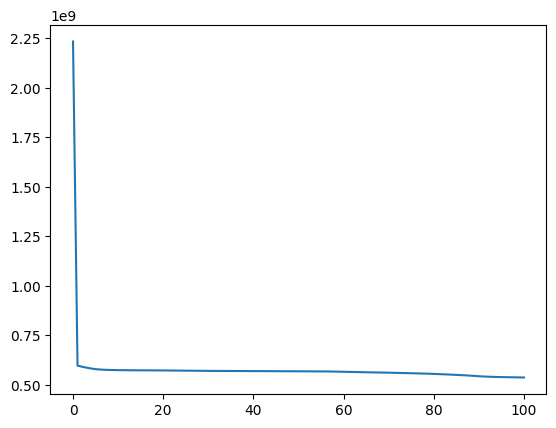

In [ ]:
losses_all = []
for epoch in range(101):
    losses = torch.empty(0)

    for x_example, y_example in dataloader:
        y_pred = model(x_example)
        loss = criterion(y_pred, y_example)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = torch.cat((losses, loss.view(1)))



    if epoch % 25 == 0:
        print('epoch', epoch, 'loss', losses.mean().item())
    losses_all.append(losses.mean().item())

plt.plot(losses_all);